# Projeto 2 - Ciência dos Dados
## 2020.2 ~ 2C ~ Estudo do stat "Velocidade" dos Pokémons
### Grupo:
    -Guilherme Rameh
    -Tales Oliveira
    -Gabriella Zullo
    -João Magalhães

In [1]:
import scipy.stats as stats
from scipy.stats import t, norm, probplot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt, ceil
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D

# Para ter melhor print
from IPython.display import display

In [2]:
# Leitura do banco de dados

dados = pd.read_csv('pokemon.csv')
dados

,abilities,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,...,percentage_male,pokedex_number,sp_attack,sp_defense,speed,type1,type2,weight_kg,generation,is_legendary
0,"['Overgrow', 'Chlorophyll']",1.00,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,1,65,65,45,grass,poison,6.9,1,0
1,"['Overgrow', 'Chlorophyll']",1.00,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,2,80,80,60,grass,poison,13.0,1,0
2,"['Overgrow', 'Chlorophyll']",1.00,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,3,122,120,80,grass,poison,100.0,1,0
3,"['Blaze', 'Solar Power']",0.50,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,...,88.1,4,60,50,65,fire,NaN,8.5,1,0
4,"['Blaze', 'Solar Power']",0.50,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,...,88.1,5,80,65,80,fire,NaN,19.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,['Beast Boost'],0.25,1.0,0.5,2.0,0.5,1.0,2.0,0.5,1.0,...,NaN,797,107,101,61,steel,flying,999.9,7,1
797,['Beast Boost'],1.00,1.0,0.5,0.5,0.5,2.0,4.0,1.0,1.0,...,NaN,798,59,31,109,grass,steel,0.1,7,1
798,['Beast Boost'],2.00,0.5,2.0,0.5,4.0,2.0,0.5,1.0,0.5,...,NaN,799,97,53,43,dark,dragon,888.0,7,1
799,['Prism Armor'],2.00,2.0,1.0,1.0,1.0,0.5,1.0,1.0,2.0,...,NaN,800,127,89,79,psychic,NaN,230.0,7,1


# Primeira Análise Exploratória
A seguir, verificaremos quais variáveis achamos interessantes de se relacionar com a velocidade dos Pokémons, que é nossa variável *Target*. Começamos printando as colunas do dataframe, pois sabendo do que se trata, podemos descartar algumas colunas logo de cara (como por exemplo as colunas referentes a quanto de dano cada ataque dá em cada tipo de Pokémon).

In [3]:
print(dados.dtypes)

abilities             object
against_bug          float64
against_dark         float64
against_dragon       float64
against_electric     float64
against_fairy        float64
against_fight        float64
against_fire         float64
against_flying       float64
against_ghost        float64
against_grass        float64
against_ground       float64
against_ice          float64
against_normal       float64
against_poison       float64
against_psychic      float64
against_rock         float64
against_steel        float64
against_water        float64
attack                 int64
base_egg_steps         int64
base_happiness         int64
base_total             int64
capture_rate          object
classfication         object
defense                int64
experience_growth      int64
height_m             float64
hp                     int64
japanese_name         object
name                  object
percentage_male      float64
pokedex_number         int64
sp_attack              int64
sp_defense    

<b> Lembrete: Quando lidando com duas variáveis QUANTITATIVAS, usamos scatter plot, e para variáveis QUALITATÍVAS (como estamos lidando com "speed", que é quantitativo) podemos separar por index e fazer crosstab, ou usar o comando pivot table do pandas, que permite a análise de várias variáveis qualitativas em relação a quantitativas, permitindo até o uso de comandos como média, máx e mín.

### Primeiras modificações no Dataframe

A seguir, manipulamos o dataframe com o intuito de analisar a relação da velocidade com as principais variáveis quantitativas, como ataque, defesa, etc...; Para evitar confusões e dificuldade na leitura dos gráficos, primeiro separamos os tipos de pokémons nos mais frequentes, tanto para o *tipo 1* quanto para o *tipo 2*. Nessa etapa também separamos o dataframe em dois, um de treino e um para testarmos o quão fíel é o nosso modelo.

In [4]:
for i in dados.index:
    type1 = dados.type1[i]
    if type1 == 'water':
        dados.loc[dados.index==i, 'Type1Reorder'] = 'water'
    elif type1 == 'normal':
        dados.loc[dados.index==i, 'Type1Reorder'] = 'normal'
    else:
        dados.loc[dados.index==i, 'Type1Reorder'] = 'other'
        
    type2 = dados.type2[i]
    if type2 == 'flying':
        dados.loc[dados.index==i, 'Type2Reorder'] = 'flying'
    elif type2 == 'ground':
        dados.loc[dados.index==i, 'Type2Reorder'] = 'ground'
    else:
        dados.loc[dados.index==i, 'Type2Reorder'] = 'other'
        
dados.tail(20)

,abilities,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,...,sp_attack,sp_defense,speed,type1,type2,weight_kg,generation,is_legendary,Type1Reorder,Type2Reorder
781,"['Bulletproof', 'Soundproof', 'Overcoat']",1.00,1.0,2.0,0.5,2.0,1.00,0.5,1.0,1.0,...,45,45,45,dragon,NaN,29.7,7,0,other,other
782,"['Bulletproof', 'Soundproof', 'Overcoat']",0.50,0.5,2.0,0.5,4.0,1.00,0.5,2.0,1.0,...,65,70,65,dragon,fighting,47.0,7,0,other,other
783,"['Bulletproof', 'Soundproof', 'Overcoat']",0.50,0.5,2.0,0.5,4.0,1.00,0.5,2.0,1.0,...,100,105,85,dragon,fighting,78.2,7,0,other,other
784,"['Electric Surge', 'Telepathy']",0.50,0.5,0.0,0.5,1.0,0.50,1.0,0.5,1.0,...,95,75,130,electric,fairy,20.5,7,1,other,other
785,"['Psychic Surge', 'Telepathy']",1.00,1.0,0.0,1.0,1.0,0.25,1.0,1.0,2.0,...,130,115,95,psychic,fairy,18.6,7,1,other,other
786,"['Grassy Surge', 'Telepathy']",1.00,0.5,0.0,0.5,1.0,0.50,2.0,2.0,1.0,...,85,95,75,grass,fairy,45.5,7,1,other,other
787,"['Misty Surge', 'Telepathy']",0.50,0.5,0.0,2.0,1.0,0.50,0.5,1.0,1.0,...,95,130,85,water,fairy,21.2,7,1,water,other
788,['Unaware'],2.00,2.0,1.0,1.0,1.0,0.50,1.0,1.0,2.0,...,29,31,37,psychic,NaN,0.1,7,1,other,other
789,['Sturdy'],2.00,2.0,1.0,1.0,1.0,0.50,1.0,1.0,2.0,...,29,131,37,psychic,NaN,999.9,7,1,other,other
790,['Full Metal Body'],1.00,2.0,0.5,1.0,0.5,1.00,2.0,0.5,2.0,...,113,89,97,psychic,steel,230.0,7,1,other,other


In [5]:
lista_train_test = train_test_split(dados, shuffle=True)
train = lista_train_test[0]
test = lista_train_test[1]

# size = 600
# list_of_dfs = [shuffle.iloc[:600,:], shuffle.iloc[600:,:]]
# train = list_of_dfs[0]
# test = list_of_dfs[1]

In [6]:
# Aqui vemos a quantidade de cada tipo, 1 e 2, na base de treino

print(train['type1'].value_counts())
print('\n')
print(train['type2'].value_counts())

water       90
normal      78
grass       61
bug         53
rock        37
fire        37
psychic     37
electric    31
ground      24
poison      22
steel       20
ghost       20
dragon      20
ice         18
dark        18
fighting    18
fairy       14
flying       2
Name: type1, dtype: int64


flying      71
ground      26
psychic     25
fairy       23
poison      23
fighting    21
steel       17
dark        16
dragon      12
water       12
grass       12
ice         12
rock        10
ghost       10
fire         9
electric     7
bug          4
normal       2
Name: type2, dtype: int64


### Análise com o modelo de distribuição "Normal"

Na célula seguinte, usamos o *probplot* e um histograma para analisar a normalidade da variável 'velocidade'. Podemos ver que ela não se distancia tanto da normal, principalmente na cauda esquerda.

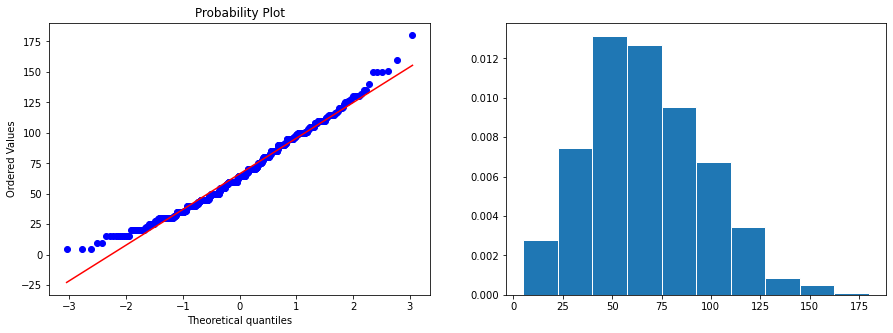

In [7]:
plt.figure(figsize=(15,5))

plt.subplot(121)
probplot(train['speed'], dist='norm', plot=plt)

plt.subplot(122)
plt.hist(train['speed'], density=True, edgecolor='w');

## Plot inicial
Como maneira de visualizar melhor se as variáveis tem relação ao *Target*, plotamos os gráficos *scatterplot* de relação entre as diversas variáveis quantitativas, além de separar por tipos de Pokémon, para ver se com isso conseguíamos visualizar alguma relação, que como se perceberá logo, é bem difícil.

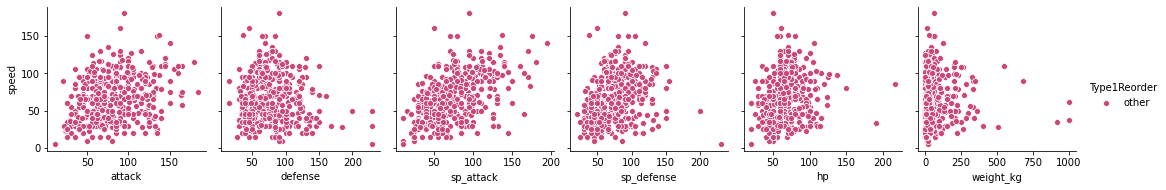

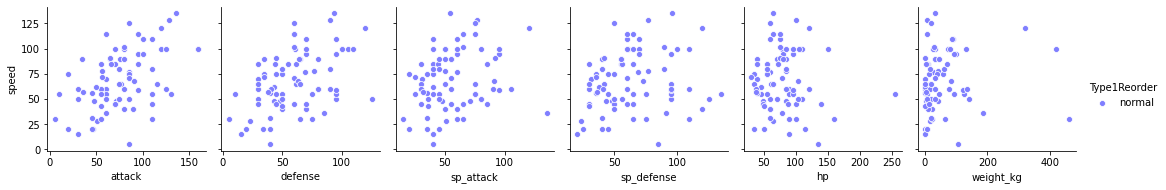

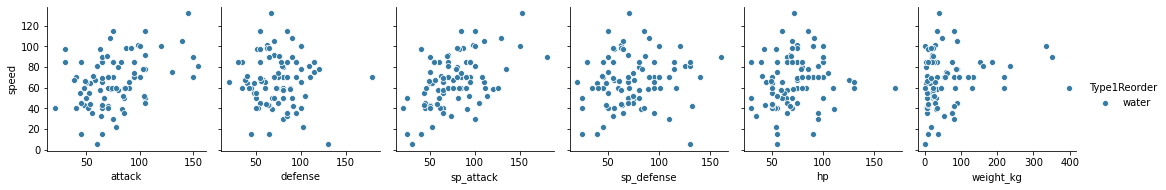

In [8]:
listType1 = train.Type1Reorder.unique()
listType2 = train.Type2Reorder.unique()
colorlist = ['plasma', 'cool', 'mako']

for i in range(3):
    e = listType1[i]
    df = train.loc[train.Type1Reorder==e, :]
    sns.pairplot(df, palette=colorlist[i],
        x_vars=["attack", 'defense', 'sp_attack', 'sp_defense', 'hp', 'weight_kg'],
        y_vars=['speed'],
        hue='Type1Reorder', height=2.5);

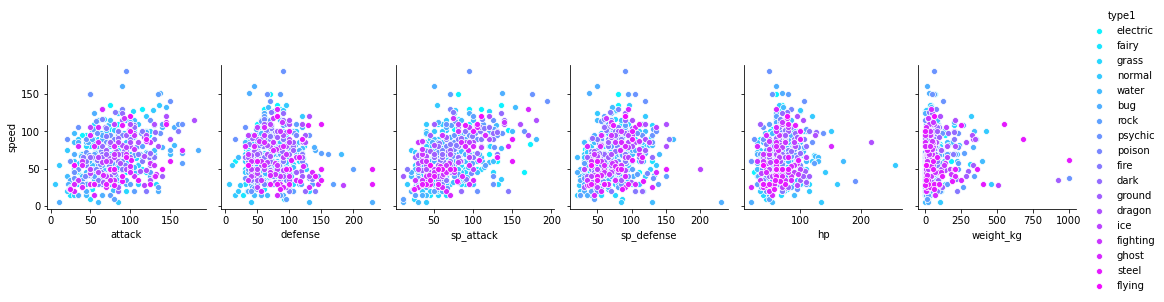

In [9]:
sns.pairplot(train,
        x_vars=["attack", 'defense', 'sp_attack', 'sp_defense', 'hp', 'weight_kg'],
        y_vars=['speed'], palette='cool',hue='type1', height=2.5);

## Regressão
Percebendo que assim não conseguiríamos identificar nenhuma relação, optamos por usar a biblioteca <b>statsmodel.api</b> para fazer a regressão pelo método dos Mínimos Quadrados. 

*Usamos apenas algumas variáveis, pois no contexto do dataframe e do jogo Pokémon sabemos que fazem referência a outros detalhes que não vão influenciar na velocidade do Pokémon, além de alguns conterem termos NaN, que atrapalham o uso deles como treino*

In [10]:
X = train[['attack', 'defense', 'sp_attack', 'sp_defense', 'hp', 'is_legendary', 'generation', 'experience_growth']]

Y = train[['speed']]

In [11]:
def regress(Y,X):
    '''
    Y: coluna do DataFrame utilizada como variável resposta (TARGET)
    X: coluna(s) do DataFrame utilizadas como variável(is) explicativas (FEATURES)
    '''
    X_cp = sm.add_constant(X)
    model = sm.OLS(Y,X_cp)
    results = model.fit()
    
    return results

In [12]:
results = regress(Y,X)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  speed   R-squared:                       0.352
Model:                            OLS   Adj. R-squared:                  0.343
Method:                 Least Squares   F-statistic:                     40.17
Date:                Wed, 18 Nov 2020   Prob (F-statistic):           3.69e-51
Time:                        14:48:03   Log-Likelihood:                -2748.9
No. Observations:                 600   AIC:                             5516.
Df Residuals:                     591   BIC:                             5555.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                44.3560      7.921      5.600      0.000      28.800      59.912
attack                0.3222      0.039      8.303      0.000       0.246       0.398
defense              -0.2884      0.041     -7.008      0.000      -0.369      -0.208
sp_attack             0.2950      0.038      7.728      0.000       0.220       0.370
sp_defense            0.1214      0.047      2.561      0.011       0.028       0.214
hp                   -0.1537      0.045     -3.414      0.001      -0.242      -0.065
is_legendary         18.0755      4.003      4.515      0.000      10.213      25.938
generation           -1.5077      0.518     -2.912      0.004      -2.525      -0.491
experience_growth  2.703e-06    6.9e-06      0.392      0.695   -1.08e-05    1.62e-05
==============================================================================
Omnibus:                       23.447   Durbin-Watson:                   2.097
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               26.044
Skew:                           0.444   Prob(JB):                     2.21e-06
Kurtosis:                       3.503   Cond. No.                     8.99e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.99e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

- Analisando os resultados acima, percebemos que TODOS (com excessão de "experience_growth") são importantes para definir nossa variável *Target*, ou seja, a velocidade ("speed"). Apesar disso, nosso P é bem pequeno, o que não é um bom sinal, e portanto precisaremos de mais regressões se quisermos atingir a normalidade e poder prever fielmente nosso *Target*.

## Análise Rápida da previsão "como está"
Apenas para visualizarmos, abaixo segue o plot do predict (ou seja, a previsão que a biblioteca $sm$ faz) relacionado com os valores reais do nosso dataframe *teste*.

In [15]:
X_test = test[['attack', 'defense', 'sp_attack', 'sp_defense', 'hp', 'is_legendary', 'generation', 'experience_growth']]

Y_test = test[['speed']]

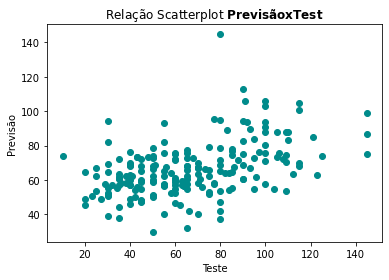

In [16]:
X_cp = sm.add_constant(X_test)
Y_predTest = results.predict(X_cp)

plt.title(r'Relação Scatterplot $\bf{Previsão x Test}$')
plt.xlabel('Teste')
plt.ylabel('Previsão')
plt.scatter(Y_test, Y_predTest, color='darkcyan');

## Aprofundamento na Análise Exploratória
Para aprimorarmos nossa previsão da velocidade dos Pokémons, precisamos também considerar variáveis <b>qualitativas</b>. Porém, a biblioteca $sm$ lida apenas com variáveis <b>quantitativas</b>. Como podemos então transformar essas variáveis para podermos analisar melhor nosso dataframe? A resposta é: com $Dummies$. Dummies é um comando da biblioteca $pandas$ que transforma as strings de uma classificação qualitativa em colunas de um dataframe assumindo valores de 0 ou 1, que equivalem a False e True, respectivamente. Assim, podemos usar essas novas colunas para uma análise exploratória mais aprofundada.

### Type 1

In [17]:
dummies_type1 = pd.get_dummies(train['type1'])
dummies_type2 = pd.get_dummies(train['type2'])

In [18]:
X_Type1 = dummies_type1 
X_Type2 = dummies_type2

In [19]:
results = regress(Y,X_Type1)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  speed   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     2.928
Date:                Wed, 18 Nov 2020   Prob (F-statistic):           7.52e-05
Time:                        14:48:39   Log-Likelihood:                -2854.5
No. Observations:                 600   AIC:                             5745.
Df Residuals:                     582   BIC:                             5824.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         63.9239      1.613     39.621      0.000      60.755      67.093
bug           -2.9805      4.053     -0.735      0.462     -10.940       4.979
dark          13.0761      6.580      1.987      0.047       0.152      26.000
dragon        15.3761      6.263      2.455      0.014       3.075      27.678
electric      21.5922      5.122      4.216      0.000      11.533      31.652
fairy         -7.0668      7.411     -0.954      0.341     -21.623       7.489
fighting       5.1872      6.580      0.788      0.431      -7.737      18.111
fire          10.6166      4.733      2.243      0.025       1.321      19.912
flying        24.0761     19.206      1.254      0.211     -13.645      61.798
ghost         -6.6739      6.263     -1.066      0.287     -18.975       5.628
grass         -6.8256      3.823     -1.786      0.075     -14.333       0.682
ground        -4.5489      5.755     -0.790      0.430     -15.853       6.755
ice           -4.3128      6.580     -0.655      0.512     -17.237       8.611
normal         4.4094      3.463      1.273      0.203      -2.393      11.211
poison         1.8942      5.992      0.316      0.752      -9.874      13.662
psychic       12.2112      4.733      2.580      0.010       2.915      21.507
rock          -4.2753      4.733     -0.903      0.367     -13.571       5.021
steel        -10.2739      6.263     -1.640      0.101     -22.575       2.028
water          2.4427      3.278      0.745      0.456      -3.995       8.880
==============================================================================
Omnibus:                       20.019   Durbin-Watson:                   2.082
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               21.280
Skew:                           0.460   Prob(JB):                     2.39e-05
Kurtosis:                       3.077   Cond. No.                     1.47e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.02e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

## Analisando a regressão da variável Tipo 1
Analisando essa primeira tabela da regressão, percebe-se uma forte relação dos tipos electric, fire e flying com a velocidade. Seguimos aprofundando na análise. 

In [20]:
X_Type1 = dummies_type1.loc[:, ['electric', 'fire', 'flying']]
results = regress(Y,X_Type1)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  speed   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     6.549
Date:                Wed, 18 Nov 2020   Prob (F-statistic):           0.000232
Time:                        14:48:39   Log-Likelihood:                -2869.4
No. Observations:                 600   AIC:                             5747.
Df Residuals:                     596   BIC:                             5764.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         64.5585      1.259     51.275      0.000      62.086      67.031
electric      20.9576      5.356      3.913      0.000      10.439      31.477
fire           9.9820      4.929      2.025      0.043       0.302      19.662
flying        23.4415     20.535      1.142      0.254     -16.887      63.771
==============================================================================
Omnibus:                       18.886   Durbin-Watson:                   2.097
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               20.132
Skew:                           0.449   Prob(JB):                     4.25e-05
Kurtosis:                       2.985   Cond. No.                         17.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Type 2

In [21]:
results = regress(Y,X_Type2)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  speed   R-squared:                       0.116
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     4.238
Date:                Wed, 18 Nov 2020   Prob (F-statistic):           1.61e-08
Time:                        14:48:40   Log-Likelihood:                -2842.2
No. Observations:                 600   AIC:                             5722.
Df Residuals:                     581   BIC:                             5806.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         63.0694      1.653     38.154      0.000      59.823      66.316
bug           -6.3194     14.123     -0.447      0.655     -34.059      21.420
dark          18.6806      7.205      2.593      0.010       4.529      32.832
dragon         6.3472      8.265      0.768      0.443      -9.886      22.580
electric       3.6448     10.731      0.340      0.734     -17.432      24.721
fairy          4.1479      6.078      0.682      0.495      -7.791      16.086
fighting      20.4067      6.341      3.218      0.001       7.953      32.861
fire           8.8194      9.496      0.929      0.353      -9.831      27.470
flying        21.6629      3.717      5.828      0.000      14.362      28.963
ghost         -8.0694      9.024     -0.894      0.372     -25.793       9.654
grass          2.2639      8.265      0.274      0.784     -13.969      18.497
ground        -9.9541      5.745     -1.733      0.084     -21.237       1.329
ice           -6.2361      8.265     -0.755      0.451     -22.469       9.997
normal        24.9306     19.905      1.252      0.211     -14.164      64.025
poison         2.3219      6.078      0.382      0.703      -9.617      14.260
psychic        8.6506      5.849      1.479      0.140      -2.837      20.138
rock         -28.8694      9.024     -3.199      0.001     -46.593     -11.146
steel         -4.5989      7.002     -0.657      0.512     -18.351       9.153
water        -10.2361      8.265     -1.238      0.216     -26.469       5.997
==============================================================================
Omnibus:                       23.327   Durbin-Watson:                   2.149
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.105
Skew:                           0.497   Prob(JB):                     3.54e-06
Kurtosis:                       3.125   Cond. No.                         17.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Analisando a regressão da variável Tipo 2
Analisando essa tabela da regressão, percebe-se uma forte relação dos tipos2 fighting, flying, e rock com a velocidade. Seguimos aprofundando na análise. 

In [22]:
X_Type2 = dummies_type2.loc[:, ['fighting', 'flying', 'rock']]
results = regress(Y,X_Type2)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  speed   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     18.54
Date:                Wed, 18 Nov 2020   Prob (F-statistic):           1.64e-11
Time:                        14:48:40   Log-Likelihood:                -2852.4
No. Observations:                 600   AIC:                             5713.
Df Residuals:                     596   BIC:                             5730.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         63.6345      1.263     50.403      0.000      61.155      66.114
fighting      19.8417      6.276      3.161      0.002       7.515      32.168
flying        21.0979      3.574      5.903      0.000      14.079      28.117
rock         -29.4345      8.998     -3.271      0.001     -47.107     -11.762
==============================================================================
Omnibus:                       23.873   Durbin-Watson:                   2.130
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.918
Skew:                           0.509   Prob(JB):                     2.36e-06
Kurtosis:                       3.049   Cond. No.                         7.90
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Regressão Aprofundada
Agora que temos alguma noção de quais variáveis importam para nós e quais não, podemos fazer uma regressão apenas com essas variáveis, e ver se conseguimos usar esse modelo para prever com mais precisão a base de *teste*.

In [24]:
# Type1 importantes: electric, fire, flying
# Type2 importantes: fighting, flying, rock

Type1Imp = ['electric', 'fire', 'flying']
Type2Imp = ['fighting', 'flying', 'rock']

# Usaremos essas listas para criar colunas personalizadas no dataframe Train para poder diferenciar type1 de type2
# Assim, já podemos aproveitar e usar os dataframse de Dummies para isso

for i in range(3):
    train.loc[:,'T1_'+Type1Imp[i]] = dummies_type1[Type1Imp[i]]
    train.loc[:,'T2_'+Type2Imp[i]] = dummies_type2[Type2Imp[i]]
    
train

E:\Arquivos de Programas\Anaconda\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,abilities,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,...,generation,is_legendary,Type1Reorder,Type2Reorder,T1_electric,T2_fighting,T1_fire,T2_flying,T1_flying,T2_rock
603,['Levitate'],1.00,1.0,1.0,0.5,1.0,1.00,1.0,0.5,1.0,...,5,0,other,other,1,0,0,0,0,0
467,"['Hustle', 'Serene Grace', 'Super Luck']",0.25,0.5,0.0,2.0,1.0,0.25,1.0,1.0,1.0,...,4,0,other,flying,0,0,0,1,0,0
548,"['Chlorophyll', 'Own Tempo', 'Leaf Guard']",2.00,1.0,1.0,0.5,1.0,1.00,2.0,2.0,1.0,...,5,0,other,other,0,0,0,0,0,0
241,"['Natural Cure', 'Serene Grace', 'Healer']",1.00,1.0,1.0,1.0,1.0,2.00,1.0,1.0,0.0,...,2,0,normal,other,0,0,0,0,0,0
170,"['Volt Absorb', 'Illuminate', 'Water Absorb']",1.00,1.0,1.0,1.0,1.0,1.00,0.5,0.5,1.0,...,2,0,water,other,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
470,"['Snow Cloak', 'Ice Body']",1.00,1.0,1.0,1.0,1.0,2.00,2.0,1.0,1.0,...,4,0,other,other,0,0,0,0,0,0
734,"['Stakeout', 'Strong Jaw', 'Adaptability']",1.00,1.0,1.0,1.0,1.0,2.00,1.0,1.0,0.0,...,7,0,normal,other,0,0,0,0,0,0
549,"['Reckless', 'Rock Head', 'Adaptability', 'Mol...",1.00,1.0,1.0,2.0,1.0,1.00,0.5,1.0,1.0,...,5,0,water,other,0,0,0,0,0,0
281,"['Synchronize', 'Trace', 'Telepathy']",1.00,1.0,0.0,1.0,1.0,0.25,1.0,1.0,2.0,...,3,0,other,other,0,0,0,0,0,0


In [31]:
X_comp = train[['attack', 'defense', 'sp_attack', 'sp_defense', 'hp', 'is_legendary', 'generation',
                'T1_electric', 'T2_fighting', 'T1_fire', 'T2_flying', 'T1_flying', 'T2_rock']]

In [32]:
results = regress(Y,X_comp)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  speed   R-squared:                       0.409
Model:                            OLS   Adj. R-squared:                  0.396
Method:                 Least Squares   F-statistic:                     31.17
Date:                Wed, 18 Nov 2020   Prob (F-statistic):           1.32e-58
Time:                        14:59:46   Log-Likelihood:                -2721.5
No. Observations:                 600   AIC:                             5471.
Df Residuals:                     586   BIC:                             5533.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           42.1741      4.119     10.238      0.000      34.083      50.265
attack           0.3010      0.038      7.964      0.000       0.227       0.375
defense         -0.2349      0.042     -5.652      0.000      -0.317      -0.153
sp_attack        0.2712      0.037      7.264      0.000       0.198       0.345
sp_defense       0.1263      0.046      2.770      0.006       0.037       0.216
hp              -0.1376      0.043     -3.173      0.002      -0.223      -0.052
is_legendary    17.0134      3.697      4.601      0.000       9.752      24.275
generation      -1.5701      0.500     -3.143      0.002      -2.551      -0.589
T1_electric     14.6905      4.329      3.393      0.001       6.188      23.193
T2_fighting     10.2926      5.295      1.944      0.052      -0.107      20.693
T1_fire          0.4796      3.974      0.121      0.904      -7.325       8.284
T2_flying       19.0961      2.927      6.523      0.000      13.347      24.845
T1_flying       18.8604     16.304      1.157      0.248     -13.161      50.881
T2_rock         -9.9071      7.692     -1.288      0.198     -25.014       5.199
==============================================================================
Omnibus:                       17.837   Durbin-Watson:                   2.112
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               18.995
Skew:                           0.388   Prob(JB):                     7.50e-05
Kurtosis:                       3.396   Cond. No.                     2.98e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.98e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [35]:
# T1_fire, T1_flying e T2_rock não são importantes, e podemos descartá-los

X_comp = train[['attack', 'defense', 'sp_attack', 'sp_defense', 'hp', 'is_legendary', 'generation',
                'T1_electric', 'T2_fighting', 'T2_flying']]

results = regress(Y,X_comp)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  speed   R-squared:                       0.406
Model:                            OLS   Adj. R-squared:                  0.396
Method:                 Least Squares   F-statistic:                     40.23
Date:                Wed, 18 Nov 2020   Prob (F-statistic):           2.35e-60
Time:                        15:01:51   Log-Likelihood:                -2723.0
No. Observations:                 600   AIC:                             5468.
Df Residuals:                     589   BIC:                             5516.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           42.4728      4.105     10.346      0.000      34.410      50.535
attack           0.3027      0.038      8.030      0.000       0.229       0.377
defense         -0.2516      0.040     -6.325      0.000      -0.330      -0.173
sp_attack        0.2752      0.037      7.437      0.000       0.203       0.348
sp_defense       0.1319      0.045      2.911      0.004       0.043       0.221
hp              -0.1407      0.043     -3.252      0.001      -0.226      -0.056
is_legendary    17.5295      3.679      4.765      0.000      10.304      24.755
generation      -1.5122      0.498     -3.034      0.003      -2.491      -0.533
T1_electric     14.4794      4.313      3.357      0.001       6.009      22.950
T2_fighting     10.3933      5.247      1.981      0.048       0.088      20.699
T2_flying       19.0695      2.926      6.518      0.000      13.324      24.815
==============================================================================
Omnibus:                       17.792   Durbin-Watson:                   2.111
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               18.838
Skew:                           0.392   Prob(JB):                     8.12e-05
Kurtosis:                       3.372   Cond. No.                         966.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [53]:
# Mais uma vez, mas agora vamos remover todos aqueles que não têm pelo menos 3 casas decimais de 0 (o valor deve ser 0.000)
# Esses valores são: sp_defense, generation, T2_fighting

X_comp = train[['attack', 'defense', 'sp_attack', 'hp', 'is_legendary', 'T1_electric', 'T2_flying']]

results = regress(Y,X_comp)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  speed   R-squared:                       0.385
Model:                            OLS   Adj. R-squared:                  0.377
Method:                 Least Squares   F-statistic:                     52.87
Date:                Wed, 18 Nov 2020   Prob (F-statistic):           1.62e-58
Time:                        15:09:43   Log-Likelihood:                -2733.5
No. Observations:                 600   AIC:                             5483.
Df Residuals:                     592   BIC:                             5518.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           39.0301      3.697     10.557      0.000      31.769      46.291
attack           0.2906      0.037      7.863      0.000       0.218       0.363
defense         -0.1950      0.035     -5.603      0.000      -0.263      -0.127
sp_attack        0.3142      0.035      9.093      0.000       0.246       0.382
hp              -0.1172      0.043     -2.721      0.007      -0.202      -0.033
is_legendary    17.7141      3.664      4.835      0.000      10.519      24.909
T1_electric     14.0884      4.374      3.221      0.001       5.499      22.678
T2_flying       18.5305      2.959      6.263      0.000      12.720      24.341
==============================================================================
Omnibus:                       16.360   Durbin-Watson:                   2.087
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.086
Skew:                           0.380   Prob(JB):                     0.000195
Kurtosis:                       3.326   Cond. No.                         732.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Ajustando o Dataframe *Test*
Sabendo o que estamos indo atrás agora, para podermos usar o comando *.predict*, precisamos preparar o df *test* para ter as mesmas colunas relativas a ele que usaremos no df *train*. As próximas células fazem exatamente isso.

In [54]:
dummies_Test_type1 = pd.get_dummies(test['type1'])
dummies_Test_type2 = pd.get_dummies(test['type2'])

Type1Imp = ['electric', 'fire', 'flying']
Type2Imp = ['fighting', 'flying', 'rock']

for i in range(3):
    test.loc[:,'T1_'+Type1Imp[i]] = dummies_Test_type1[Type1Imp[i]]
    test.loc[:,'T2_'+Type2Imp[i]] = dummies_Test_type2[Type2Imp[i]]
    
test

E:\Arquivos de Programas\Anaconda\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,abilities,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,...,generation,is_legendary,Type1Reorder,Type2Reorder,T1_electric,T2_fighting,T1_fire,T2_flying,T1_flying,T2_rock
58,"['Intimidate', 'Flash Fire', 'Justified']",0.50,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,...,1,0,other,other,0,0,1,0,0,0
230,"['Pickup', 'Sand Veil']",1.00,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,2,0,other,other,0,0,0,0,0,0
728,"['Torrent', 'Liquid Voice']",1.00,1.0,1.0,2.0,1.0,1.0,0.5,1.0,1.0,...,7,0,water,other,0,0,0,0,0,0
333,"['Natural Cure', 'Cloud Nine']",0.50,1.0,2.0,1.0,2.0,0.5,0.5,1.0,1.0,...,3,0,other,flying,0,0,0,1,0,0
512,"['Gluttony', 'Blaze']",0.50,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,...,5,0,other,other,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
797,['Beast Boost'],1.00,1.0,0.5,0.5,0.5,2.0,4.0,1.0,1.0,...,7,1,other,other,0,0,0,0,0,0
214,"['Inner Focus', 'Keen Eye', 'Pickpocket']",2.00,0.5,1.0,1.0,2.0,4.0,2.0,1.0,0.5,...,2,0,other,other,0,0,0,0,0,0
112,"['Natural Cure', 'Serene Grace', 'Healer']",1.00,1.0,1.0,1.0,1.0,2.0,1.0,1.0,0.0,...,1,0,normal,other,0,0,0,0,0,0
743,"['Keen Eye', 'Vital Spirit', 'Steadfast']",1.00,1.0,1.0,1.0,1.0,2.0,0.5,0.5,1.0,...,7,0,other,other,0,0,0,0,0,0


In [56]:
X_TesteComp = test[['attack', 'defense', 'sp_attack', 'hp', 'is_legendary', 'T1_electric', 'T2_flying']]

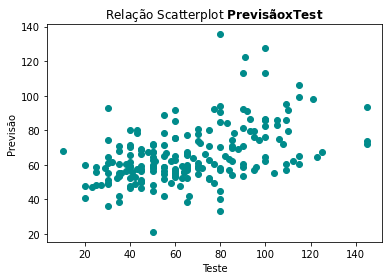

In [57]:
X_cnt = sm.add_constant(X_TesteComp)
Y_predTest = results.predict(X_cnt)

plt.title(r'Relação Scatterplot $\bf{Previsão x Test}$')
plt.xlabel('Teste')
plt.ylabel('Previsão')
plt.scatter(Y_test, Y_predTest, color='darkcyan');